# Neuroblastoma

## Imports python

In [144]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torchmetrics.classification as classification
import copy
import matplotlib.pyplot as plt
import numpy as np
import json
import os

from torch import nn


## Vérification GPU

In [145]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Chargement des datasets et preprocessing

In [146]:
# root_dir  = "../database/224x224_split_BA"
root_dir  = "../database/db_mat_224_FA"
train_dir = "train/"
# valid_dir = "validation/"
valid_dir = "test/"
test_dir  = "test/"

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.644193498371542, 0.5645996565889991, 0.7588836765196458), (0.21690568815789038, 0.2163005157370828, 0.13590056909053988))
    transforms.Normalize((0.6675633854729178, 0.5748515449722628, 0.7695707113605876), (0.21134008037102184, 0.2146980755715314, 0.1345160446951044))
])

# Chargement des données
train_dataset = datasets.ImageFolder(f"{root_dir}/{train_dir}", transform)
valid_dataset = datasets.ImageFolder(f"{root_dir}/{valid_dir}", transform)
test_dataset  = datasets.ImageFolder(f"{root_dir}/{test_dir}",  transform)

## Modèle

In [147]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d((2,2)),
            nn.Flatten()
        )
        self.nn = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        a = self.cnn(x)
        b = self.nn(a)
        return b

## Entraînement

In [148]:
batch_size = 32
lr = 1e-5
epochs = 1

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr, betas=(0.9, 0.999))
criterion = nn.BCELoss()
accuracy  = classification.BinaryAccuracy().to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size, shuffle=False)

In [149]:
def train_model(model, loader, criterion, accuracy, epoch:int=0):
    loss, accu = np.zeros((len(loader))), np.zeros((len(loader)))
    accuracy.reset()
    model.train()
    for b, (inputs, labels) in enumerate(loader):
        (inputs, labels) = (inputs.to(device), labels.to(device))
        labels  = labels.unsqueeze(1).to(torch.float32)
        outputs = model(inputs)
        cr_loss = criterion(outputs, labels)

        optimizer.zero_grad()
        cr_loss.backward()
        optimizer.step()

        loss[b] = cr_loss.item()
        accu[b] = accuracy(outputs, labels).item()
    mean_loss = np.mean(loss)
    mean_accu = np.mean(accu)
    return mean_loss, loss, mean_accu, accu


def eval_model(model, loader, criterion, accuracy, epoch:int=0):
    loss, accu = np.zeros((len(loader))), np.zeros((len(loader)))
    accuracy.reset()
    model.eval()
    with torch.no_grad():    
        for b, (inputs, labels) in enumerate(loader):
            (inputs, labels) = (inputs.to(device), labels.to(device))
            labels  = labels.unsqueeze(1).to(torch.float32)
            outputs = model(inputs)

            cr_loss = criterion(outputs, labels)
            loss[b] = cr_loss.item()
            accu[b] = accuracy(outputs, labels).item()
    mean_loss = np.mean(loss)
    mean_accu = np.mean(accu)
    return mean_loss, loss, mean_accu, accu

def print_H_at_epoch(H, e:int=0):
    print(f"Epoch {e:3d}: Train=({H['train']['m_loss'][e]:.3f}, {H['train']['m_accu'][e]:.2%})", end=" | ")
    print(              f"Valid=({H['valid']['m_loss'][e]:.3f}, {H['valid']['m_accu'][e]:.2%})")
    
# Historic
H = {
    "train": {"loss":   np.zeros((epochs+1, len(train_loader))),
              "accu":   np.zeros((epochs+1, len(train_loader))),
              "m_loss": np.zeros((epochs+1)),
              "m_accu": np.zeros((epochs+1))},
    "valid": {"loss":   np.zeros((epochs+1, len(valid_loader))),
              "accu":   np.zeros((epochs+1, len(valid_loader))),
              "m_loss": np.zeros((epochs+1)),
              "m_accu": np.zeros((epochs+1))}
}

(H["train"]["m_loss"][0], H["train"]["loss"][0, :],
 H["train"]["m_accu"][0], H["train"]["accu"][0, :]) = eval_model(model, train_loader, criterion, accuracy, epoch=0)
(H["valid"]["m_loss"][0], H["valid"]["loss"][0, :],
 H["valid"]["m_accu"][0], H["valid"]["accu"][0, :]) = eval_model(model, valid_loader, criterion, accuracy, epoch=0)

print_H_at_epoch(H, 0)
best_valid_accu = H["valid"]["m_accu"][0]
best_model = copy.deepcopy(model)

for e in range(1, epochs+1):
    (H["train"]["m_loss"][e], H["train"]["loss"][e, :],
     H["train"]["m_accu"][e], H["train"]["accu"][e, :]) = train_model(model, train_loader, criterion, accuracy, e)
    
    (H["valid"]["m_loss"][e], H["valid"]["loss"][e, :],
     H["valid"]["m_accu"][e], H["valid"]["accu"][e, :]) = eval_model(model, valid_loader, criterion, accuracy, e)

    print_H_at_epoch(H, e)
    if H["valid"]["m_accu"][e] > best_valid_accu:
        best_valid_accu = H["valid"]["m_accu"][e]
        best_model = copy.deepcopy(model)

(mean_loss, loss, mean_accu, accu) = eval_model(best_model, test_loader, criterion, accuracy)
print(f"Best model: ({mean_loss:.3f}, {mean_accu:.2%})")

Epoch  0: Train=(0.695, 48.31%) | Valid=(0.700, 39.47%)
Epoch  1: Train=(0.579, 74.45%) | Valid=(0.759, 61.90%)
Best model: Loss=0.759 | Acc=0.619


## Visualisation des courbes d'apprentissage

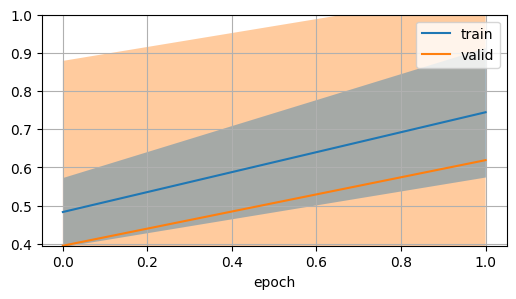

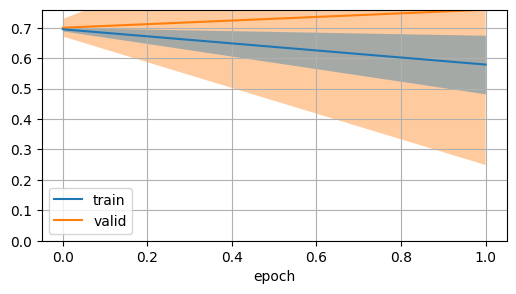

In [151]:
os.makedirs("backup", exist_ok=True)
backup_folder = "backup/new"
os.makedirs(backup_folder, exist_ok=True)

def plot_metric(H, max_epoch:int, metric:str="accu"):
    fig = plt.figure(figsize=(6, 3))

    cmap = plt.get_cmap("tab10")
    colors = [cmap(1), cmap(0)]
    xline = np.arange(max_epoch+1)
    handles = []
    labels = ["valid", "train"]

    for c, dataset in zip(colors, labels):
        std  = np.sqrt(np.var(H[dataset][metric], axis=1))[:max_epoch+1]
        mean = H[dataset][f"m_{metric}"][:max_epoch+1]
        plt.fill_between(xline, mean-std, mean+std, linewidth=0, color=c, alpha=0.4)
        line, = plt.plot(xline, mean, color=c)
        handles += [line]

    plt.xlabel("epoch")
    if metric == "accu":
        plt.ylim([min(min(H["train"]["m_accu"]), min(H["valid"]["m_accu"])), 1])
    elif metric == "loss":
        plt.ylim([0, max(max(H["train"][f"m_loss"]), max(H["valid"][f"m_loss"]))])
    plt.legend(handles[::-1], labels[::-1])
    plt.grid()
    
    
plot_metric(H, max_epoch=epochs, metric="accu")
plt.savefig(f"{backup_folder}/accu.pdf", bbox_inches="tight")
plot_metric(H, max_epoch=epochs, metric="loss")
plt.savefig(f"{backup_folder}/loss.pdf", bbox_inches="tight")

## Sauvegarde

In [152]:
torch.save(model.state_dict(), f"{backup_folder}/model.pth")

backup = {}
backup["loader"] = {"train": len(train_loader), "valid": len(valid_loader), "test": len(test_loader)}
backup["opti"]   = {"optimizer": "Adam", "lr": lr, "batch_size": batch_size, "epochs": epochs}
backup["train_loss"] = H["train"]["m_loss"].tolist()
backup["train_accu"] = H["train"]["m_accu"].tolist()
backup["valid_loss"] = H["valid"]["m_loss"].tolist()
backup["valid_accu"] = H["valid"]["m_accu"].tolist()
backup["train_loss_batch"] = H["train"]["loss"].tolist()
backup["train_accu_batch"] = H["train"]["accu"].tolist()
backup["valid_loss_batch"] = H["valid"]["loss"].tolist()
backup["valid_accu_batch"] = H["valid"]["accu"].tolist()

with open(f"{backup_folder}/backup.json", "w") as fd:
    json.dump(backup, fd)